In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
from random import uniform, seed
from math import sqrt
import numpy as np
from Cell2D import Cell2D, draw_array
from matplotlib.colors import LinearSegmentedColormap
from scipy import signal
import seaborn as sns
from matplotlib import cm
from numpy import random
palette = sns.color_palette()
colors = 'white', 'red', 'blue', 'orange'
cmap = LinearSegmentedColormap.from_list('cmap', colors)
import warnings
warnings.filterwarnings("ignore")

In [123]:
# Defining a cmap that we can use where zeros (empty houses) will stand out - setting them to black
cmap_show_empty = cm.Greens.copy()
cmap_show_empty.set_bad(color='red')
cmap.set_under('black')
#cmap_show_empty.set_bad(color='red', alpha = 1)

In [125]:
seed(10)

In [198]:
# Defining a class for the houses
class grid_houses(Cell2D):
    """Represents a grid of Schelling agents."""
    
    def __init__(self, n, prob_empty,kernel,seed):
        """Initializes the attributes.
        
        n: is the dimension of our square numpy array (n x n)

        """
        super().__init__(n)
        self.prob_empty = prob_empty    # probability of empty cells occurring
        self.kernel = kernel
        self.size = n

        choices = np.array([0,1])
        probs1 = [1/3, 1/3, 1/3]
        choices1 = np.array([0.1,0.5,1], dtype = np.int8)
        self.values = np.random.rand(n,n)
        np.random.seed(seed)
        self.array = np.random.choice(2, (n, n), p = [prob_empty, 1-prob_empty]) # randomly choosing which houses are empty, with probability prob_empty
        self.padding = np.ones_like(self.array)
        self.padding[0,:] = np.zeros_like(self.padding[0,:])
        self.padding[1,:] = np.zeros_like(self.padding[1,:])
        self.padding[-1,:] = np.zeros_like(self.padding[-1,:])
        self.padding[-2,:] = np.zeros_like(self.padding[-2,:])
        self.padding[:,0] = np.zeros_like(self.padding[:,0])
        self.padding[:,1] = np.zeros_like(self.padding[:,1])
        self.padding[:,-1] = np.zeros_like(self.padding[:,-1])
        self.padding[:,-2] = np.zeros_like(self.padding[:,-2])

        self.array = np.multiply(self.padding, self.array) # setting the house indicator to zero for the padding
        self.values= np.multiply(self.values, self.array) # sets the house values to zero if there is no house at that spot

    def average_neighbors(self):
        '''
        calculates the of the values of neighbors' house values, where the radius is defined by the kernel matrix. Note - boundary = fill automatically 'pads' the matrix with zeros on the boundary, which leads to lower averages there, so lower house prices near the boundary. We should look into a wrap boundary or possibly filling with a different value, eg average house price.
        :return: array of the averages
        '''
        total = signal.convolve2d(self.values, self.kernel, boundary='wrap', mode='same')
        # adding the number of total grid points
        number = signal.convolve2d(self.array, self.kernel, boundary='wrap', mode='same')

        # finding the average
        average = np.zeros_like(self.array, dtype = float)
        average[2:-2,2:-2] += np.divide(total[2:-2,2:-2],number[2:-2,2:-2])


        # resetting the values to zero for squares that don't have a house
        output = np.multiply(self.array,average)
        output = np.multiply(output, self.array) # setting the house indicator to zero for the padding
        return(output)

    def draw_values(self):
        '''
        Just defined a function to draw the house values so we can draw both a map of houses and a map of house values
        '''
        # mask some 'bad' data, in your case you would have: data == 0
        values = np.ma.masked_where(self.values == 0, self.values)
        return draw_array(values[2:-2,2:-2], cmap = cmap_show_empty)

    def update_values(self, grid_agents, lam):
        '''
        Coding for the function we use to update house prices, at a matrix level. We can use
        :param grid_agents:
        :param lam:
        :return:
        '''
        self.values = lam*self.average_neighbors() + grid_agents.affluences

    def draw_neighbors(self):
        return draw_array(self.average_neighbors())


In [199]:
# Defining a class for the agents
class grid_agents(Cell2D):
    """Represents a grid of Schelling agents."""

    def __init__(self, n, prob_empty,grid_houses):
        """Initializes the attributes.
        """
        super().__init__(n)
        self.prob_emp = prob_empty    # probability of empty cells occurring
        self.size = n
        choices = np.array([0.1,.5,1])
        probs = [1/3, 1/3, 1/3]
        self.affluences = np.random.rand(n,n)
        self.affluences = np.multiply(self.affluences,grid_houses.array)


    def draw(self):
        """Draws the cells."""
        return draw_array(self.array, cmap=cmap, vmax=3)

    def draw_affluences(self):
        '''
        Draws the grid of affluences.
        '''
        # mask some 'bad' data, in your case you would have: data == 0
        affluences = np.ma.masked_where(self.affluences == 0, self.affluences)
        return draw_array(affluences, cmap = cmap_show_empty)

    def swap_people(self, grid_houses):
        '''
        Picks two random grid elements, if they aren't zero and the delta function is greater than 0, swaps them
        :param grid_houses: we need this as an input, since we need to get house values for the two agents, for the delta function.
        :return:
        '''
        i1 = random.randint(2,self.size-2)
        j1 = random.randint(2,self.size-2)
        i2 = random.randint(2,self.size -2)
        j2 = random.randint(2,self.size-2)

        if j1 != j2 or i1 != i2:
            if grid_houses.array[i1][j1] != 0 and grid_houses.array[i2][j2] != 0:
                t1 = (grid_houses.values[i1][j1]- self.affluences[i1][j1])**2 + (grid_houses.values[i2][j2]- self.affluences[i2][j2])**2
                t2 = (grid_houses.values[i1][j1]- self.affluences[i2][j2])**2 + (grid_houses.values[i2][j2]- self.affluences[i1][j1])**2
                if t1 > t2:
                    self.affluences[i2,j2], self.affluences[i1,j1] = self.affluences[i1,j1],self.affluences[i2,j2]

    def swap_exists(self, grid_houses):
        '''
        Picks two random grid elements, if they aren't zero and the delta function is greater than 0, swaps them
        :param grid_houses: we need this as an input, since we need to get house values for the two agents, for the delta function.
        :return:
        '''
        print(self.affluences)
        print(grid_houses.values)
        x1 = range(self.array.shape[1])
        x2 = range(self.array.shape[0])
        y1 =range(self.array.shape[1])
        y2 =range(self.array.shape[0])
        x1 = list(x1)
        x2 = list(x2)
        y1 = list(y1)
        y2 = list(y2)
        random.shuffle(x1)
        random.shuffle(x2)
        random.shuffle(y1)
        random.shuffle(y2)

        for i1 in x1:
            for j1 in x2:
                for i2 in y1:
                    for j2 in y2:
                        if j1 != j2 or i1 != i2:
                            if grid_houses.array[i1][j1] != 0 and grid_houses.array[i2][j2] != 0:
                                t1 = (grid_houses.values[i1][j1]- self.affluences[i1][j1])**2 + (grid_houses.values[i2][j2]- self.affluences[i2][j2])**2
                                t2 = (grid_houses.values[i1][j1]- self.affluences[i2][j2])**2 + (grid_houses.values[i2][j2]- self.affluences[i1][j1])**2
                                # print("t1 =",t1)
                                # print("t2 =",t2)
                                if t1 > t2:
                                    return True
        return False

In [200]:
# kernel used for counting a cell's neighbours
kernel = np.array([[1,1,1, 1, 1],
                   [1,1,1, 1, 1],
                   [1,1, 1, 1,1],
                   [1,1,1, 1, 1],
                   [1,1,1, 1, 1]], dtype=np.int8)

## Running the code (100,000 times)

# Calculating Inequality

In [201]:
def inequality(A):
    """
    Function to find inequality given the aflluence matrix A
    """
    poor = 0
    middle = 0
    rich = 0

    for x in range(np.shape(A)[0]):
        for y in range(np.shape(A)[1]):
            if float(A[x,y]) == 0.1:
                poor += 1
            elif float(A[x,y]) == 0.5:
                middle += 1
            elif float(A[x,y]) == 1.0:
                rich += 1
    sum = poor+middle+rich
    print(f'{np.log(3)}+{poor/sum}*{np.log(poor/sum)}')
    I = np.log(3) + (poor/sum) * np.log(poor/sum) + (middle/sum) * np.log(middle/sum) + (rich/sum) * np.log(rich/sum)
    return(I)

In [202]:
def theil_inequality(A):
    B = A.copy()[2:-2,2:-2]
    avg = np.average(B)
    print('average = ', avg)
    L= B/avg
    T = np.nan_to_num(L* np.log( L ) )
    return T.mean()

In [203]:
inequality_values = []
print(np.log(3))

for x in range(0,10):
    grid_houses1 = grid_houses(19,.1, kernel)
    grid_agents1 = grid_agents(19, 0.1, grid_houses1)
    inequality_values.append(theil_inequality(grid_agents1.affluences))
    print('Theil: ', theil_inequality(grid_agents1.affluences))

1.0986122886681098


TypeError: grid_houses.__init__() missing 1 required positional argument: 'seed'

# Making a graph of (inflation)

# Getting convergence rates for different $\lambda$

In [204]:
def get_convergence(lam, gridsize, p_empty, seed):
    grid_houses1 = grid_houses(gridsize + 4,p_empty, kernel, seed)
    grid_agents1 = grid_agents(gridsize + 4, p_empty, grid_houses1)
    i = 0
    j = 0
    while i < int(gridsize**(2)/300):
        grid_houses1.update_values(grid_agents1, lam)
        g1 = grid_agents1.affluences.copy()
        grid_agents1.swap_people(grid_houses1)
        g2 = grid_agents1.affluences
        if np.array_equal(g1,g2):
            i += 1
        else:
            i = 0
        j += 1
    H = get_eigenvalues(grid_houses1)
    return j, np.average(grid_houses1.values), H

In [205]:
# graphing 'convergence' for different values of lambda
lambdas = []
convergence = []
inflation = []

for t in range(1,50):
    lam = t/50
    conv, inf = get_convergence(lam, 20, 0.2, 0)
    lambdas.append(lam)
    convergence.append(conv)
    inflation.append(inf)

[-1.4329873 +0.j         -1.22329517-0.93931141j -1.22329517+0.93931141j
 -1.1076409 +0.j         -0.27435851+0.j         -0.18274792-0.47120691j
 -0.18274792+0.47120691j -0.05818095-0.87114738j -0.05818095+0.87114738j
 -0.01152486-0.10764707j -0.01152486+0.10764707j  0.11079398+0.j
  0.38833625-0.87545216j  0.38833625+0.87545216j  0.41867608+0.j
  0.90644913-0.4106694j   0.90644913+0.4106694j   1.41638765-0.8489729j
  1.41638765+0.8489729j ]


ValueError: too many values to unpack (expected 2)

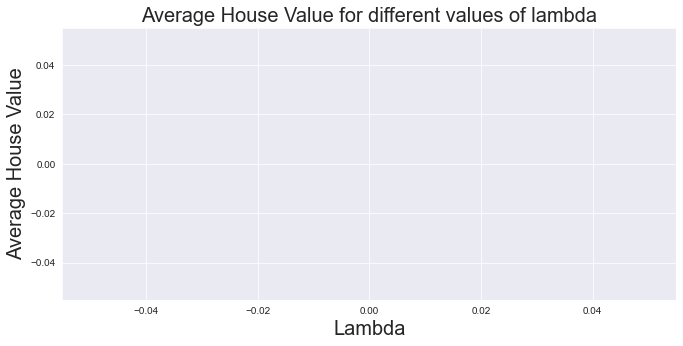

In [206]:
plt.plot(lambdas, inflation)
plt.title('Average House Value for different values of lambda',fontsize=20)
plt.xlabel('Lambda',fontsize=20)
plt.ylabel('Average House Value',fontsize=20)
plt.savefig('lambda_inflation_2.pdf',fontsize=20)

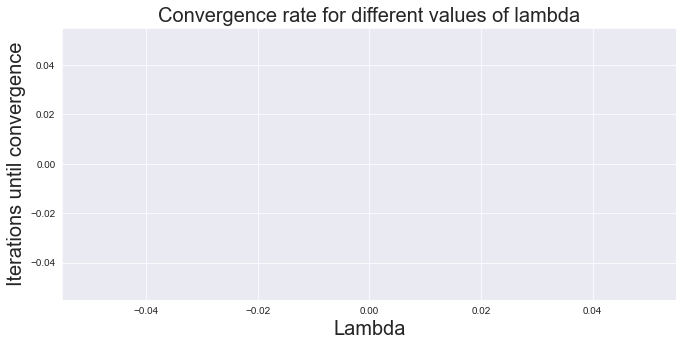

In [207]:
plt.plot(lambdas, convergence)
plt.title('Convergence rate for different values of lambda',fontsize=20)
plt.xlabel('Lambda',fontsize=20)
plt.ylabel('Iterations until convergence',fontsize=20)
plt.savefig('lambda_convergence_2.pdf')

In [ ]:
# graphing 'inflation' for different values of lambda
lambdas = []
convergence = []

for t in range(1,50):
    print(t)
    lam = t/50
    conv = get_convergence(lam, 20, 0.2)
    lambdas.append(lam)
    convergence.append(conv)

# Getting a plot for the report

In [160]:
def get_plots(lam, gridsize, p_empty, file_name):
    i = 0
    j = 0
    maxi = 0
    grid_houses1 = grid_houses(gridsize + 4,p_empty, kernel, seed =None)
    grid_agents1 = grid_agents(gridsize + 4, p_empty, grid_houses1)
    plt.subplot(1,2,1)
    grid_houses1.draw_values()
    plt.colorbar()
    plt.title(f'Initial')
    while i < gridsize**2/300:
        grid_houses1.update_values(grid_agents1, lam)
        g1 = grid_agents1.affluences.copy()
        grid_agents1.swap_people(grid_houses1)
        g2 = grid_agents1.affluences
        if np.array_equal(g1,g2):
            i += 1
        else:
            if i >= maxi:
                maxi = i
                print("maxi = ",maxi)
            i = 0
        j += 1
        if j % 25000 == 0:
            print(j)
    plt.subplot(1,2,2)
    H = get_eigenvalues(grid_houses1)
    print(f'Segregation ',H )
    print(f'Average House Value: ',np.average(grid_houses1.values) )
    grid_houses1.draw_values()
    plt.title(f'Converged')
    plt.colorbar()
    plt.savefig(f'{file_name}.pdf')
    #1

In [ ]:
get_plots(0.5, 50, 0.2, 'new_plot')

maxi =  0
maxi =  60
maxi =  65


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000015B3BF2C9D0> (for post_execute):


In [208]:
# Defining a class for the agents
class grid_agents_gamma(Cell2D):
    """Represents a grid of Schelling agents."""

    def __init__(self, n, prob_empty,grid_houses, shape, scale):
        """Initializes the attributes.
        """
        super().__init__(n)
        self.prob_emp = prob_empty    # probability of empty cells occurring
        self.size = n
        choices = np.array([0.1,.5,1])
        probs = [1/3, 1/3, 1/3]
        self.affluences = np.random.gamma(shape, scale, size = (n,n))
        self.affluences = np.multiply(self.affluences,grid_houses.array)


    def draw(self):
        """Draws the cells."""
        return draw_array(self.array, cmap=cmap, vmax=3)

    def draw_affluences(self):
        '''
        Draws the grid of affluences.
        '''
        # mask some 'bad' data, in your case you would have: data == 0
        affluences = np.ma.masked_where(self.affluences == 0, self.affluences)
        return draw_array(affluences, cmap = cmap_show_empty)

    def swap_people(self, grid_houses):
        '''
        Picks two random grid elements, if they aren't zero and the delta function is greater than 0, swaps them
        :param grid_houses: we need this as an input, since we need to get house values for the two agents, for the delta function.
        :return:
        '''
        i1 = random.randint(2,self.size-2)
        j1 = random.randint(2,self.size-2)
        i2 = random.randint(2,self.size -2)
        j2 = random.randint(2,self.size-2)

        if j1 != j2 or i1 != i2:
            if grid_houses.array[i1][j1] != 0 and grid_houses.array[i2][j2] != 0:
                t1 = (grid_houses.values[i1][j1]- self.affluences[i1][j1])**2 + (grid_houses.values[i2][j2]- self.affluences[i2][j2])**2
                t2 = (grid_houses.values[i1][j1]- self.affluences[i2][j2])**2 + (grid_houses.values[i2][j2]- self.affluences[i1][j1])**2
                if t1 > t2:
                    self.affluences[i2,j2], self.affluences[i1,j1] = self.affluences[i1,j1],self.affluences[i2,j2]

    def swap_exists(self, grid_houses):
        '''
        Picks two random grid elements, if they aren't zero and the delta function is greater than 0, swaps them
        :param grid_houses: we need this as an input, since we need to get house values for the two agents, for the delta function.
        :return:
        '''
        print(self.affluences)
        print(grid_houses.values)
        x1 = range(self.array.shape[1])
        x2 = range(self.array.shape[0])
        y1 =range(self.array.shape[1])
        y2 =range(self.array.shape[0])
        x1 = list(x1)
        x2 = list(x2)
        y1 = list(y1)
        y2 = list(y2)
        random.shuffle(x1)
        random.shuffle(x2)
        random.shuffle(y1)
        random.shuffle(y2)

        for i1 in x1:
            for j1 in x2:
                for i2 in y1:
                    for j2 in y2:
                        if j1 != j2 or i1 != i2:
                            if grid_houses.array[i1][j1] != 0 and grid_houses.array[i2][j2] != 0:
                                t1 = (grid_houses.values[i1][j1]- self.affluences[i1][j1])**2 + (grid_houses.values[i2][j2]- self.affluences[i2][j2])**2
                                t2 = (grid_houses.values[i1][j1]- self.affluences[i2][j2])**2 + (grid_houses.values[i2][j2]- self.affluences[i1][j1])**2
                                # print("t1 =",t1)
                                # print("t2 =",t2)
                                if t1 > t2:
                                    return True
        return False

In [209]:
# getting convergence for gamma distributed affluence
def get_gamma_convergence(lam, gridsize, p_empty,gamma_shape,gamma_scale, seed):
    '''Returns the number of iterations required to converge, the average house value, and the theil index in that order'''
    grid_houses1 = grid_houses(gridsize + 4,p_empty, kernel, seed)
    grid_agents1 = grid_agents_gamma(gridsize + 4, p_empty, grid_houses1, gamma_shape, gamma_scale)
    T = theil_inequality(grid_agents1.affluences)
    i = 0
    j = 0
    while i < int(gridsize**(2)):
        grid_houses1.update_values(grid_agents1, lam)
        g1 = grid_agents1.affluences.copy()
        grid_agents1.swap_people(grid_houses1)
        g2 = grid_agents1.affluences
        if np.array_equal(g1,g2):
            i += 1
        else:
            i = 0
        j += 1
    H = get_eigenvalues(grid_houses1)
    return j, np.average(grid_houses1.values), T, H

In [210]:
def number_of_it_against_theil(gridsize,steps, seed= None):
     
    #creates the graph for number of iterations against theil index
    teil_values = []
    iterations = []
    for x in range (steps):
            gamma_shape = 10**(-x/50)
            gamma_scale = 1/(2*gamma_shape)
            values = get_gamma_convergence(0.5, gridsize, 0.2,gamma_shape,gamma_scale, seed)
            iterations.append(values[0])
            teil_values.append(values[2])
            
    plt.scatter(teil_values,iterations)
    plt.title(f'Theil Index vs iterations to convergence')
    plt.xlabel(f'Theil Index')
    plt.ylabel(f'Iterations to convergence')
    plt.savefig('thiel_index_graph.pdf')

In [37]:
number_of_it_against_theil(20,20,0)

average =  0.3910543885174378
[-2.52772898+0.j         -0.56933285-0.09585647j -0.56933285+0.09585647j
 -0.49356968-0.76570398j -0.49356968+0.76570398j -0.44702704-1.18111966j
 -0.44702704+1.18111966j -0.02349879-0.48200836j -0.02349879+0.48200836j
  0.01510224-0.26551999j  0.01510224+0.26551999j  0.12333023+0.j
  0.35674125-0.1963866j   0.35674125+0.1963866j   0.8803237 +0.j
  1.2209828 -1.29224724j  1.2209828 +1.29224724j  3.09696058-0.55245935j
  3.09696058+0.55245935j]
average =  0.40731181957813517
[-2.20197804+0.j         -1.44657504-0.51768475j -1.44657504+0.51768475j
 -1.24968665+0.j         -1.00654673+0.j         -0.35852857-0.62516229j
 -0.35852857+0.62516229j -0.09446842-0.26453977j -0.09446842+0.26453977j
  0.34514436+0.j          0.45968243-1.20632562j  0.45968243+1.20632562j
  0.79233092+0.j          0.80880706-0.57551837j  0.80880706+0.57551837j
  1.21778504-0.49950371j  1.21778504+0.49950371j  4.77728657+0.j
  6.31313925+0.j        ]
average =  0.4138073675556707


KeyboardInterrupt: 

In [ ]:
plt.scatter(teil_values,iterations)
plt.title(f'Theil Index vs iterations to convergence')
plt.xlabel(f'Theil Index')
plt.ylabel(f'Iterations to convergence')
plt.savefig('thiel_index_graph_1.pdf')

## Getting the segregation index


In [22]:
# getting the eigenvalues
def get_eigenvalues(houses):
    real_values = houses.values[2:-2, 2:-2]
    w, v = np.linalg.eig(real_values)
    w.sort()
    w = w[:-1]
    print(w)
    values, counts = np.unique(w, return_counts=True)
    p = []
    for i in counts:
        p.append(i/sum(counts))
    p = np.array(p)
    H = np.log(3*(houses.size-4)/5 - sum(np.multiply(p, np.log(p))))
    return H

In [27]:
gridsize = 20
p_empty = 0.2
grid_houses1 = grid_houses(gridsize + 4,p_empty, kernel, seed = None)

In [28]:
print(get_eigenvalues(grid_houses1))

[-1.43566904-0.50416871j -1.43566904+0.50416871j -0.94144431-0.28659795j
 -0.94144431+0.28659795j -0.68678135-0.3441569j  -0.68678135+0.3441569j
 -0.51981706-0.74523715j -0.51981706+0.74523715j -0.32319266+0.j
 -0.01942524+0.j          0.30756642-0.6752654j   0.30756642+0.6752654j
  0.32841918-0.1798692j   0.32841918+0.1798692j   0.86893997-0.84138729j
  0.86893997+0.84138729j  0.91907017-0.91814938j  0.91907017+0.91814938j
  1.08672798+0.j        ]
2.7043392559992725


In [25]:
get_plots(0.5, 25, 0.2, 'new_plot')

NameError: name 'get_plots' is not defined

In [26]:
print(get_eigenvalues(grid_houses1))

[-1.16229745-0.48554075j -1.16229745+0.48554075j -0.89814523+0.j
 -0.74355393-0.65913951j -0.74355393+0.65913951j -0.43561668-1.31346108j
 -0.43561668+1.31346108j -0.43286118-0.02027175j -0.43286118+0.02027175j
  0.33104744+0.j          0.36216032-0.39305803j  0.36216032+0.39305803j
  0.60251291-1.31823364j  0.60251291+1.31823364j  0.78751134-0.52574462j
  0.78751134+0.52574462j  0.79369214+0.j          1.2457329 -0.20912251j
  1.2457329 +0.20912251j]
2.7043392559992725


In [14]:
# Making a graph of segregation indexes compared to lambda:
gridsize = 20
p_empty = 0.2
lams = []
segs = []
for s in range(1,21):
    lam = s/20
    _,_, seq = get_convergence(lam, gridsize, p_empty, seed = 0)
    lams.append(lam)
    segs.append(seq)

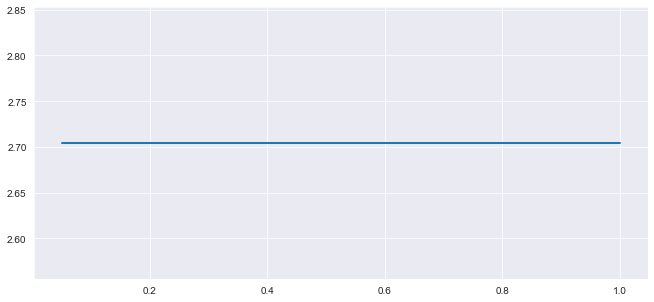

In [15]:
plt.plot(lams,segs)

In [96]:
shape =  1.563529**(-1)
scale =  1/(2*shape)

## Working on mean satisfaction

In [217]:
def mean_satisfaction(agents, houses):
    return np.sqrt(((houses.average_neighbors() - agents.affluences)**2).sum())

In [221]:
# plotting mean satisfaction against iterations
def get_mean_sat(lam, gridsize, p_empty, seed):
    mean_sats = []
    its = []
    i = 0
    j = 0
    grid_houses1 = grid_houses(gridsize + 4,p_empty, kernel, seed)
    grid_agents1 = grid_agents_gamma(gridsize + 4, p_empty, grid_houses1, shape, scale)

    while i < int(gridsize**(2)/3):
        grid_houses1.update_values(grid_agents1, lam)
        g1 = grid_agents1.affluences.copy()
        grid_agents1.swap_people(grid_houses1)
        g2 = grid_agents1.affluences
        if np.array_equal(g1,g2):
            i += 1
        else:
            i = 0
        j += 1
        its.append(j)
        m= mean_satisfaction(grid_agents1, grid_houses1)
        mean_sats.append(m)
    return j, np.average(grid_houses1.values), its, mean_sats

In [222]:
_,_, its, sats = get_mean_sat(0.5, 25, 0.2, 2)

In [110]:
print(sats[10], sats[20], sats[30], sats[40], sats[50])

7.988514913110092 7.985662917413975 7.985495291871802 7.985493880146229 7.985493878163528


In [227]:
print(sats[3])

18.55470914665801


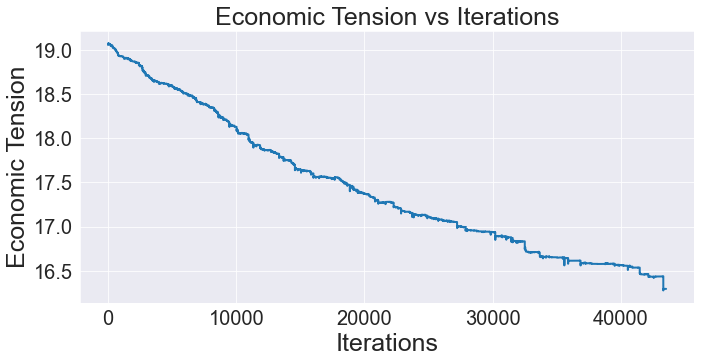

In [229]:
plt.plot(its[8:],sats[8:])
plt.title('Economic Tension vs Iterations', fontsize = 25)
plt.xlabel('Iterations', fontsize = 25)
plt.ylabel('Economic Tension', fontsize = 25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.savefig('its_ten.pdf',bbox_inches='tight')

## Adding high value zones

In [132]:
eps = np.spacing(0.0)

In [230]:
class grid_houses(Cell2D):
    """Represents a grid of Schelling agents."""

    def __init__(self, n, prob_empty, prob_hv,kernel,seed):
        """Initializes the attributes.

        n: is the dimension of our square numpy array (n x n)

        """
        super().__init__(n)
        self.prob_empty = prob_empty    # probability of empty cells occurring
        self.kernel = kernel
        self.size = n

        choices = np.array([0,1])
        probs1 = [1/3, 1/3, 1/3]
        choices1 = np.array([0.1,0.5,1], dtype = np.int8)
        self.values = np.random.rand(n,n)
        np.random.seed(seed)
        self.array = np.random.choice(2, (n, n), p = [prob_empty, 1-prob_empty]) # randomly choosing which houses are empty, with probability prob_empty
        self.padding = np.ones_like(self.array)
        self.padding[0,:] = np.zeros_like(self.padding[0,:])
        self.padding[1,:] = np.zeros_like(self.padding[1,:])
        self.padding[-1,:] = np.zeros_like(self.padding[-1,:])
        self.padding[-2,:] = np.zeros_like(self.padding[-2,:])
        self.padding[:,0] = np.zeros_like(self.padding[:,0])
        self.padding[:,1] = np.zeros_like(self.padding[:,1])
        self.padding[:,-1] = np.zeros_like(self.padding[:,-1])
        self.padding[:,-2] = np.zeros_like(self.padding[:,-2])

        #self.high_value = np.random.choice(2, (n, n), p = [1-prob_hv, prob_hv])
        self.high_value = np.zeros((n,n))
        self.high_value[8:15,5:12] = 1
        self.high_value[30:34,12:24] = 1
        self.array = np.multiply(self.padding, self.array) # setting the house indicator to zero for the padding
        self.values= np.multiply(self.values, self.array) # sets the house values to zero if there is no house at that spot
        self.values = self.values - self.values*self.high_value + self.high_value

    def average_neighbors(self):
        '''
        calculates the of the values of neighbors' house values, where the radius is defined by the kernel matrix. Note - boundary = fill automatically 'pads' the matrix with zeros on the boundary, which leads to lower averages there, so lower house prices near the boundary. We should look into a wrap boundary or possibly filling with a different value, eg average house price.
        :return: array of the averages
        '''
        total = signal.convolve2d(self.values, self.kernel, boundary='wrap', mode='same')
        # adding the number of total grid points
        number = signal.convolve2d(self.array, self.kernel, boundary='wrap', mode='same')

        # finding the average
        average = np.zeros_like(self.array, dtype = float)
        average[2:-2,2:-2] += np.divide(total[2:-2,2:-2],number[2:-2,2:-2])

        # resetting the values to zero for squares that don't have a house
        output = np.multiply(self.array,average)
        output = np.multiply(output, self.array) # setting the house indicator to zero for the padding

        return(output)

    def draw_values(self):
        '''
        Just defined a function to draw the house values so we can draw both a map of houses and a map of house values
        '''
        # mask some 'bad' data, in your case you would have: data == 0
        values = np.ma.masked_where(self.values == 1, self.values)
        return draw_array(values[2:-2,2:-2], cmap = cmap_show_empty, vmin = eps)

    def update_values(self, grid_agents, lam):
        '''
        Coding for the function we use to update house prices, at a matrix level. We can use
        :param grid_agents:
        :param lam:
        :return:
        '''
        A = lam*self.average_neighbors() + grid_agents.affluences

        #making sure set high value to 1
        self.values = A - A*self.high_value + self.high_value

    def draw_neighbors(self):
        return draw_array(self.average_neighbors())


In [231]:
def get_plots(lam, gridsize, p_empty, p_hv,file_name):
    i = 0
    j = 0
    maxi = 0
    grid_houses1 = grid_houses(gridsize + 4,p_empty, p_hv, kernel, seed =None)
    grid_agents1 = grid_agents(gridsize + 4, p_empty, grid_houses1)
    plt.subplot(1,2,1)
    grid_houses1.draw_values()
    plt.colorbar()
    plt.title(f'Initial', fontsize = 25)
    while i < gridsize**2/3:
        grid_houses1.update_values(grid_agents1, lam)
        g1 = grid_agents1.affluences.copy()
        grid_agents1.swap_people(grid_houses1)
        g2 = grid_agents1.affluences
        if np.array_equal(g1,g2):
            i += 1
        else:
            if i >= maxi:
                maxi = i
                print("maxi = ",maxi)
            i = 0
        j += 1
        if j % 25000 == 0:
            print(j)
    plt.subplot(1,2,2)
    H = get_eigenvalues(grid_houses1)
    print(f'Segregation ',H )
    print(f'Average House Value: ',np.average(grid_houses1.values) )
    grid_houses1.draw_values()
    plt.title(f'Converged', fontsize = 25)
    plt.colorbar()
    plt.savefig(f'{file_name}.pdf')
    #1

maxi =  27
maxi =  73
maxi =  74
maxi =  100
maxi =  117
maxi =  120
maxi =  131
maxi =  132
25000
maxi =  140
50000
maxi =  156
maxi =  169
75000
maxi =  197
maxi =  257
100000
125000
maxi =  280
maxi =  306
maxi =  331
150000
maxi =  345
maxi =  360
175000
[-4.38184553+0.j         -3.252323  -1.90982457j -3.252323  +1.90982457j
 -2.56813583+0.j         -2.02219483+0.j         -1.84779499+0.j
 -1.77337966-0.79129114j -1.77337966+0.79129114j -1.25486864-1.57919713j
 -1.25486864+1.57919713j -1.18196153+0.j         -0.71321794-2.75747534j
 -0.71321794+2.75747534j -0.61808643-1.14427034j -0.61808643+1.14427034j
 -0.49314378-2.21611384j -0.49314378+2.21611384j -0.4446905 -0.29000306j
 -0.4446905 +0.29000306j  0.05579707-0.53294747j  0.05579707+0.53294747j
  0.12673951+0.j          0.5654523 -1.46577945j  0.5654523 +1.46577945j
  0.6960006 +0.j          0.80303472-0.68641196j  0.80303472+0.68641196j
  0.96822499+0.j          1.04321032-1.38507696j  1.04321032+1.38507696j
  1.37523875-1.0426

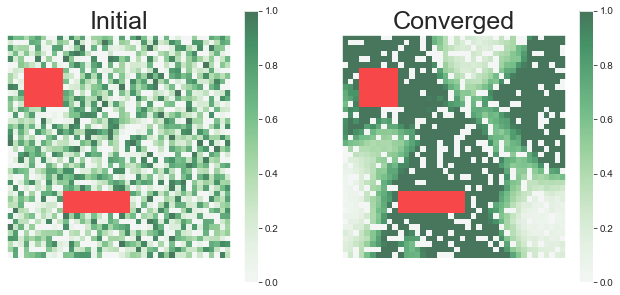

In [174]:
get_plots(0.5, 40, 0.2, 0.1,'high_value')

In [ ]:
    grid_houses1 = grid_houses(gridsize + 4,p_empty, p_hv, kernel, seed =None)
    grid_agents1 = grid_agents(gridsize + 4, p_empty, grid_houses1)

In [232]:
def get_mean_sat(lam, gridsize, p_empty, p_hv, seed):
    mean_sats = []
    its = []
    i = 0
    j = 0
    grid_houses1 = grid_houses(gridsize + 4,p_empty, p_hv, kernel, seed)
    grid_agents1 = grid_agents_gamma(gridsize + 4, p_empty, grid_houses1, shape, scale)
    its.append(j)
    m= mean_satisfaction(grid_agents1, grid_houses1)
    mean_sats.append(m)

    while i < int(gridsize**(2)/3):
        grid_houses1.update_values(grid_agents1, lam)
        g1 = grid_agents1.affluences.copy()
        grid_agents1.swap_people(grid_houses1)
        g2 = grid_agents1.affluences
        if np.array_equal(g1,g2):
            i += 1
        else:
            i = 0
        j += 1
        its.append(j)
        m= mean_satisfaction(grid_agents1, grid_houses1)
        mean_sats.append(m)
    return j, np.average(grid_houses1.values), its, mean_sats

In [233]:
_,_, its, sats = get_mean_sat(0.5, 25, 0.2,0, 2)

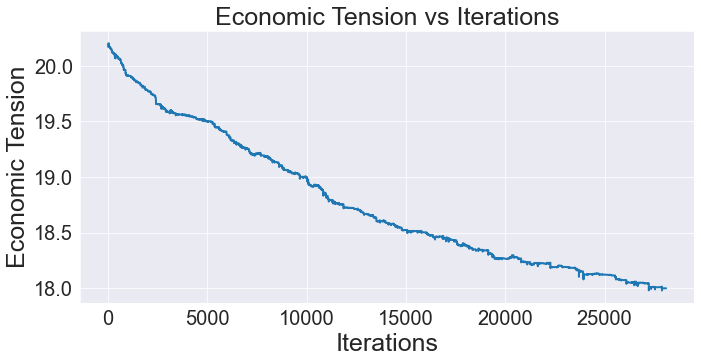

In [234]:
plt.plot(its[8:],sats[8:])
plt.title('Economic Tension vs Iterations', fontsize = 25)
plt.xlabel('Iterations', fontsize = 25)
plt.ylabel('Economic Tension', fontsize = 25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.savefig('its_diss_am.pdf',bbox_inches='tight')